# Installation

Install the necessary modules that are going to be used in the notebook.

In [ ]:
%%capture
# We will use nlpaug to augment the text samples.
!pip install nlpaug

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras import layers, optimizers

from pathlib import Path
from time import time

# Dataset creation and visualization

We use the *imdb_reviews* to demonstrate the sample efficiency improvements for text datasets. Tensorflow makes it available through *tensorflow_datasets* package. Details about the dataset are available at: [IMDB Reviews Dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

The imdb reviews dataset contains samples of labelled text. A label value 1 indicates a positive review while a value 0 implies a negative review. A few samples are shown below

| Name     | Id       |
| -------- | :------: |
| This was an absolutely terrible movie. Don't... | 0 |
| I have been known to fall asleep during...   | 0 |
| Mann photographs the Alberta Rocky Mountains in a superb fashion... | 0        |
| This is the kind of film for a snowy Sunday afternoon when... | 1 |

In this section, we will create the training and validation sets. The dataset elements are formatted as a tuple *(text, class_label)*. We expose the following objects:
* train500_ds (Training set with 500 samples)
* train1000_ds (Training set with 1000 samples)
* val_ds (Validation dataset)
* ds_info (Dataset metadata object)

In [ ]:
%%capture
read_config = tfds.ReadConfig(try_autocache=False)

(train500_ds, train1000_ds, val_ds), ds_info = tfds.load(
  name='imdb_reviews', 
  split=['train[:500]', 'train[:1000]', 'train[60%:]'],
  as_supervised=True,
  with_info=True,
  read_config=read_config
)

# Model architecture

We use a double stacked bidirectional LSTM model. The model is exposed through a **model** variable. After the creation, we save the initial weights. The initial weights are loaded prior to each run to ensure a fair comparison.

In [ ]:
LEARNING_RATE = 0.001
MAX_SEQ_LEN = 500 # The sentences are truncated to this word count.
WORD2VEC_LEN = 300 # The size of the word vector
CHKPT_DIR = Path('chkpt')
CHKPT_TMPL = Path(CHKPT_DIR, 'epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}/weights')
INITIAL_WEIGHTS = Path('initial_weights/weights')

Path(CHKPT_DIR).mkdir(parents=True, exist_ok=True)

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    layers.Bidirectional(
        layers.LSTM(64, return_sequences=True),
        input_shape=(MAX_SEQ_LEN, WORD2VEC_LEN)
    ),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
	  layers.Dropout(0.5),
    layers.Dense(20, activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
  ])
  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

  return model

model = create_model()
model.summary()
model.save_weights(INITIAL_WEIGHTS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 500, 128)         186880    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 500, 128)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                1300      
                                                                 
 flatten_2 (Flatten)         (None, 20)               

# Training functions

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train(model, tds, vds, epochs=100):
  tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
  vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE)
  
  cb_checkpoint = ModelCheckpoint(
    str(CHKPT_TMPL),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
  )
  cb_earlystopping = EarlyStopping(
    monitor='val_accuracy',
    patience= 15,
    restore_best_weights=True
  )

  callbacks = [cb_checkpoint, cb_earlystopping]
  history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

  return history

# Input Vectorization

In [ ]:
%%capture
!python -m spacy download en_core_web_md

import en_core_web_md

nlp = en_core_web_md.load()

In [ ]:
def vectorize_fn(text, label):
  def pyfn(text):
    text = np.char.decode(text.numpy().astype(np.bytes_), 'UTF-8').tolist()
    # Initialize a representation vector BATCH SIZE x MAX_SEQ_LEN x WORD2VEC_LEN with zero values
    vector = np.zeros(shape=(len(text), MAX_SEQ_LEN, WORD2VEC_LEN))

    # Fill up zero vector with the actual word vectors from the language model
    for tidx, doc in enumerate(nlp.pipe(text)):
      for didx in range(min(MAX_SEQ_LEN, len(doc))):
        vector[tidx][didx] = doc[didx].vector

    return vector

  vector = tf.py_function(pyfn, inp=[text], Tout=tf.float32)
  vector.set_shape((None, MAX_SEQ_LEN, WORD2VEC_LEN))
  return vector, label

# NLP Augmentations

In [ ]:
def nlpaug_fn(aug):
  def pyfn(text):
    text = text.numpy().decode("utf-8")
    text = aug.augment(text)
    
    return text

  def augtext(text, label):
    aug_text = tf.py_function(pyfn, inp=[text], Tout=tf.string)
    aug_text.set_shape(text.shape)

    return aug_text, label

  return augtext

# Experiments

## baseline (500 training samples)

Download complete!
Loading initial_weights...
Epoch 1/100


2021-11-09 14:44:20.431426: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 366s 12s/step - loss: 0.6981 - accuracy: 0.4860 - val_loss: 0.6880 - val_accuracy: 0.5446
Epoch 2/100
32/32 [==============================] - 23s 739ms/step - loss: 0.6822 - accuracy: 0.5740 - val_loss: 0.6779 - val_accuracy: 0.5736
Epoch 3/100
32/32 [==============================] - 23s 716ms/step - loss: 0.6453 - accuracy: 0.6520 - val_loss: 0.6729 - val_accuracy: 0.5906
Epoch 4/100
32/32 [==============================] - 23s 711ms/step - loss: 0.6470 - accuracy: 0.6360 - val_loss: 0.6736 - val_accuracy: 0.5830
Epoch 5/100
32/32 [==============================] - 23s 717ms/step - loss: 0.5896 - accuracy: 0.6980 - val_loss: 0.6533 - val_accuracy: 0.6319
Epoch 6/100
32/32 [==============================] - 23s 713ms/step - loss: 0.5422 - accuracy: 0.7560 - val_loss: 0.6850 - val_accuracy: 0.6013
Epoch 7/100
32/32 [==============================] - 23s 717ms/step - loss: 0.5048 - accuracy: 0.7640 - val_loss: 0.6756 - val_accuracy: 0.6336
Epoch

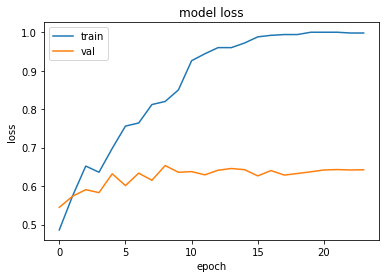

In [ ]:
tds = train500_ds.shuffle(500, reshuffle_each_iteration=True)
tds = tds.batch(16).map(vectorize_fn)
vds = val_ds.batch(64).map(vectorize_fn)

# Reset the model state before training
model.load_weights(INITIAL_WEIGHTS)
baseline500_hist = train(model, tds, vds, epochs=100)

## nlp augmentations (500 training samples)

In [ ]:
%%capture
from nltk import download as nltk_download
from nlpaug.augmenter import sentence as nas
from nlpaug.augmenter import word as naw
from nlpaug.augmenter import char as nac
from nlpaug import flow as naf

[nltk_download(item) for item in ['punkt', 'wordnet']]

aug_args = dict(aug_p=0.3, aug_max=40)

chain = [
    nas.random.RandomSentAug(**aug_args),
    naw.RandomWordAug(action='delete', **aug_args),
    naw.RandomWordAug(action='swap', **aug_args),
    naw.RandomWordAug(action='crop', **aug_args),
    naw.RandomWordAug(action='substitute', **aug_args),
    nac.KeyboardAug()
]
flow = naf.Sometimes(chain, pipeline_p=0.3)

Loading initial_weights...
Epoch 1/100
32/32 [==============================] - 25s 778ms/step - loss: 0.6983 - accuracy: 0.4940 - val_loss: 0.6925 - val_accuracy: 0.5201
Epoch 2/100
32/32 [==============================] - 24s 768ms/step - loss: 0.6927 - accuracy: 0.5180 - val_loss: 0.6993 - val_accuracy: 0.5017
Epoch 3/100
32/32 [==============================] - 25s 783ms/step - loss: 0.6893 - accuracy: 0.5540 - val_loss: 0.6897 - val_accuracy: 0.5265
Epoch 4/100
32/32 [==============================] - 24s 768ms/step - loss: 0.6847 - accuracy: 0.5680 - val_loss: 0.6847 - val_accuracy: 0.5483
Epoch 5/100
32/32 [==============================] - 25s 766ms/step - loss: 0.6729 - accuracy: 0.5760 - val_loss: 0.6806 - val_accuracy: 0.5637
Epoch 6/100
32/32 [==============================] - 25s 781ms/step - loss: 0.6444 - accuracy: 0.5980 - val_loss: 0.6664 - val_accuracy: 0.6128
Epoch 7/100
32/32 [==============================] - 24s 764ms/step - loss: 0.6460 - accuracy: 0.6260 - val_l

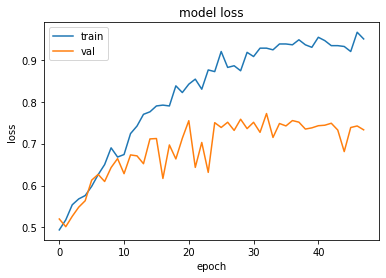

In [ ]:
tds = train500_ds.shuffle(500, reshuffle_each_iteration=True)
tds = tds.map(nlpaug_fn(flow)).batch(16).map(vectorize_fn)
vds = val_ds.batch(64).map(vectorize_fn)

model.load_weights(INITIAL_WEIGHTS)
nlpaug500_hist = train(model, tds, vds, epochs=100)

## baseline (1000 training samples)

Download complete!
Loading initial_weights...
Epoch 1/100


2021-11-09 15:38:34.694059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 380s 6s/step - loss: 0.6932 - accuracy: 0.5150 - val_loss: 0.6847 - val_accuracy: 0.5435
Epoch 2/100
63/63 [==============================] - 40s 627ms/step - loss: 0.6638 - accuracy: 0.6170 - val_loss: 0.6631 - val_accuracy: 0.6120
Epoch 3/100
63/63 [==============================] - 39s 620ms/step - loss: 0.6266 - accuracy: 0.6620 - val_loss: 0.6106 - val_accuracy: 0.6756
Epoch 4/100
63/63 [==============================] - 39s 614ms/step - loss: 0.6229 - accuracy: 0.6960 - val_loss: 0.7036 - val_accuracy: 0.5438
Epoch 5/100
63/63 [==============================] - 39s 614ms/step - loss: 0.5984 - accuracy: 0.6880 - val_loss: 0.6217 - val_accuracy: 0.6577
Epoch 6/100
63/63 [==============================] - 41s 648ms/step - loss: 0.5240 - accuracy: 0.7460 - val_loss: 0.5831 - val_accuracy: 0.7122
Epoch 7/100
63/63 [==============================] - 40s 636ms/step - loss: 0.4839 - accuracy: 0.7790 - val_loss: 0.5862 - val_accuracy: 0.7191
Epoch 

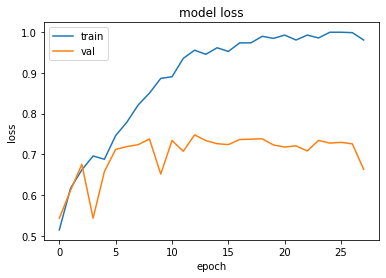

In [ ]:
tds = train1000_ds.shuffle(500, reshuffle_each_iteration=True)
tds = tds.batch(16).map(vectorize_fn)
vds = val_ds.batch(64).map(vectorize_fn)

model.load_weights(INITIAL_WEIGHTS)
baseline1000_hist = train(model, tds, vds, epochs=100)